In [17]:
from datamodule import Datamodule 
from file_parsing_utils import create_csv_dict

In [18]:
import torch

torch.cuda.is_available()

False

In [5]:
# datamodule:
#   _target_: datamodule.Datamodule
#   all_flight_dataframes_dict: /Users/aleksandranikevich/Desktop/AircraftTrajectory/data/Individual_Flights/
#   num_input_rows_total: 100
#   min_rows_input: 100
#   num_output_rows: 1
#   coordinate_system_enum: ${coordinate_system.coordinate_system.coordinate_system_enum}
#   auxiliary_input_channels: ${coordinate_system.coordinate_system.auxiliary_input_channels}
#   auxiliary_output_channels: ${coordinate_system.coordinate_system.auxiliary_output_channels}
#   train_prop: 0.8
#   batch_size: 32
#   num_workers: 4
#   pin_memory: true
#   break_after: null 

dir_csvs = '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/Individual_Flights/'
coordinate_system_enum = 'LatLongCoordinates'
auxiliary_input_channels = []
auxiliary_output_channels = []
break_after = 10

datamodule = Datamodule(all_flight_dataframes_dict = dir_csvs, 
                        num_input_rows_total= 100,
                        min_rows_input= 100,
                        num_output_rows= 1,
                        coordinate_system_enum= coordinate_system_enum,
                        auxiliary_input_channels= auxiliary_input_channels, 
                        auxiliary_output_channels= auxiliary_output_channels, 
                        train_prop= 0.8,
                        batch_size= 32,
                        num_workers= 4,
                        pin_memory= True,
                        break_after= break_after ,
                        )

In [15]:


from pathlib import Path
import os
import pandas as pd
import gzip
import shutil
import glob
from collections import defaultdict
from tqdm import tqdm

def create_csv_dict(dir_individual_flights, break_after = None):
    """
    Create nested dictionary based on dir_individual_flights
    """
    d = defaultdict(lambda: {})
    flight_folders = os.listdir(dir_individual_flights)
    idx_csv = 0
    broken = False
    for flight_folder in flight_folders:
        flight_folder_dir = dir_individual_flights + flight_folder + "/"
        if not os.path.isdir(flight_folder_dir):
            continue
    
        dict_ids = {}
        id_keys = os.listdir(flight_folder_dir) 
        for id_key in id_keys:
            id_key_dir = flight_folder_dir + id_key + "/"
            if not os.path.isdir(id_key_dir):
                continue
    
            csv_list = glob.glob(id_key_dir + "*.csv")
            if len(csv_list) > 0:
                dict_ids[id_key] = csv_list[0]
                idx_csv += 1
                if break_after is not None:
                    if idx_csv >= break_after:
                        broken = True
                        break
            
        if len(dict_ids.keys()) > 0:
            d[flight_folder] = dict_ids

        
        if broken:
            # if inner loop was broken, break outer loop due to premature stop condition
            break


    return d


In [19]:
all_flight_dataframes_dict = create_csv_dict(dir_csvs, break_after=break_after)
all_flight_dataframes_dict

defaultdict(<function file_parsing_utils.create_csv_dict.<locals>.<lambda>()>,
            {'150171': {'LTA941': '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/Individual_Flights/150171/LTA941/150171_LTA941.csv'},
             '164344': {'EJA151': '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/Individual_Flights/164344/EJA151/164344_EJA151.csv'},
             '123483': {'5112': '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/Individual_Flights/123483/5112/123483_5112.csv'},
             '90107': {'FFT3214': '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/Individual_Flights/90107/FFT3214/90107_FFT3214.csv'},
             '134434': {'AAL2762': '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/Individual_Flights/134434/AAL2762/134434_AAL2762.csv'},
             '146014': {'ASA7011': '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/Individual_Flights/146014/ASA7011/146014_ASA7011.csv'},
             '180338': {'N81866': '/Use

In [21]:
test_path = '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/Individual_Flights/150171/LTA941/150171_LTA941.csv'
os.path.basename(test_path).split(".")[0]

'150171_LTA941'

In [13]:
len(all_flight_dataframes_dict.keys())

1

In [14]:
len(  all_flight_dataframes_dict[list(all_flight_dataframes_dict.keys())[0]] )

1

In [227]:
from flight_dataset import *
from datamodule import * 
from file_parsing_utils import * 
from model import * 
from coordinate_transform import *

from copy import deepcopy
from math import radians, sin, cos, sqrt, atan2

In [1]:
# 8400
640*640

409600

In [2]:
8400/640

13.125

In [3]:
desired_features_input_and_output = ["diff_time", 
                                  "lat_complex_x", 
                                  "lat_complex_y", 
                                  "long_complex_x", 
                                  "long_complex_y", 
                                  "flight_course_corrected", 
                                  "flight_course_unknown", 
                                  "Latitude", 
                                  "Longitude"]

desired_input_features = ["diff_time", 
                          "lat_complex_x", 
                          "lat_complex_y", 
                          "long_complex_x", 
                          "long_complex_y", 
                          "flight_course_corrected", 
                          "flight_course_unknown", 
                            # "Latitude", 
                            # "Longitude"
                         ]


desired_output_features = ["lat_complex_x", 
                          "lat_complex_y", 
                          "long_complex_x", 
                          "long_complex_y"]


# net = SimpleNet(in_channels=len(desired_input_features) if desired_input_features is not None else 7, 
#                  out_channels=4, 
#                  intermediate_channels=64, 
#                  num_res_blocks=8, 
#                  num_output_rows=1, 
#                  dilation = 1, 
#                  kernel_size = 27, 
#                  use_bn_norm=True, 
#                  stride=1, 
#                  bias=True)


individual_flights_dir = "/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/Individual_Flights/"
flight_dfs = create_csv_dict(individual_flights_dir)

datamodule = Datamodule(all_flight_dataframes_dict = flight_dfs, 
                        num_input_rows_total = 1000, 
                        min_rows_input = 100, 
                        num_output_rows = 1, 
                        desired_features_input_and_output = desired_features_input_and_output, 
                        desired_input_features = desired_input_features,
                        desired_output_features = desired_output_features, 
                        train_prop = 0.8, 
                        batch_size = 32, 
                        num_workers = 0, 
                        pin_memory = True,)

train_dataloader = datamodule.train_dataloader()
test_dataloader = datamodule.test_dataloader()

# # dummy tensor
# test_dataloader_iterator = test_dataloader.__iter__()
# tensors_dict = next(test_dataloader_iterator)
# dummy_input_tensor = tensors_dict["input_tensor"]
# dummy_output = net(dummy_input_tensor)


# loss_fn = torch.nn.functional.mse_loss
# optimizer = None #                               TODO 
# model = FlightModel(net, loss_fn, optimizer, max_num_val_maps = 8, n_future_timesteps = 10, mean=0.0, std=0.00001)



In [13]:
test_dataloader_iterator = test_dataloader.__iter__()
tensors_dict = next(test_dataloader_iterator)
tensors_dict["input_tensor"].shape

torch.Size([32, 7, 1000])

In [14]:
tensors_dict["input_tensor"][0, :, -5:]

tensor([[-4.0000, -5.0000, -4.0000, -5.0000, -5.0000],
        [ 0.7323,  0.7323,  0.7323,  0.7323,  0.7323],
        [ 0.6810,  0.6810,  0.6810,  0.6810,  0.6810],
        [ 0.3180,  0.3180,  0.3180,  0.3180,  0.3181],
        [-0.9481, -0.9481, -0.9481, -0.9481, -0.9481],
        [ 0.1111,  0.1194,  0.1139,  0.1167,  0.1194],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])

In [15]:
tensors_dict["output_tensor"][0, :, -5:]

tensor([[ 0.7322],
        [ 0.6810],
        [ 0.3181],
        [-0.9481]])

In [16]:
tensors_dict["normalization_tensor"][0, :, -5:]

tensor([[ 0.7323],
        [ 0.6810],
        [ 0.3181],
        [-0.9481]])

In [18]:
tensors_dict_copy = deepcopy(tensors_dict)

In [19]:
tensors_dict_copy = normalize_center(tensors_dict_copy)

In [20]:
tensors_dict_copy["input_tensor"][0, :, -5:]

tensor([[-4.0000, -5.0000, -4.0000, -5.0000, -5.0000],
        [ 0.4590,  0.3511,  0.2342,  0.1264,  0.0000],
        [-0.4935, -0.3773, -0.2515, -0.1353,  0.0000],
        [-0.7910, -0.6023, -0.4086, -0.2217,  0.0000],
        [-0.2652, -0.2021, -0.1371, -0.0745,  0.0000],
        [ 0.1111,  0.1194,  0.1139,  0.1167,  0.1194],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])

In [21]:
tensors_dict_copy["output_tensor"][0, :, -5:]

tensor([[-0.1222],
        [ 0.1317],
        [ 0.2068],
        [ 0.0697]])

In [22]:
tensors_dict_copy = un_normalize_center(tensors_dict_copy)

In [23]:
tensors_dict_copy["input_tensor"][0, :, -5:]

tensor([[-4.0000, -5.0000, -4.0000, -5.0000, -5.0000],
        [ 0.7323,  0.7323,  0.7323,  0.7323,  0.7323],
        [ 0.6810,  0.6810,  0.6810,  0.6810,  0.6810],
        [ 0.3180,  0.3180,  0.3180,  0.3180,  0.3181],
        [-0.9481, -0.9481, -0.9481, -0.9481, -0.9481],
        [ 0.1111,  0.1194,  0.1139,  0.1167,  0.1194],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])

In [7]:
#tensors_dict["input_tensor"][0, 0, :]

In [7]:
tensors_dict_copy = deepcopy(tensors_dict)

In [8]:
tensors_dict_copy = normalize_center(tensors_dict_copy)

In [9]:
tensors_dict["input_tensor"][0, :, -5:]

tensor([[-12.0000, -12.0000, -12.0000, -12.0000, -12.0000],
        [  0.8514,   0.8513,   0.8512,   0.8512,   0.8511],
        [  0.5245,   0.5247,   0.5248,   0.5249,   0.5250],
        [  0.0307,   0.0303,   0.0299,   0.0296,   0.0292],
        [ -0.9995,  -0.9995,  -0.9996,  -0.9996,  -0.9996],
        [  0.8167,   0.8167,   0.8139,   0.8194,   0.8139],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000]])

In [10]:
tensors_dict_copy["input_tensor"][0, :, -5:] #* 1e4

tensor([[-1.2000e+01, -1.2000e+01, -1.2000e+01, -1.2000e+01, -1.2000e+01],
        [ 8.5130e+03,  8.5123e+03,  8.5116e+03,  8.5108e+03,  8.5101e+03],
        [ 5.2448e+03,  5.2460e+03,  5.2472e+03,  5.2484e+03,  5.2495e+03],
        [ 3.0655e+02,  3.0289e+02,  2.9919e+02,  2.9553e+02,  2.9183e+02],
        [-9.9943e+03, -9.9944e+03, -9.9945e+03, -9.9946e+03, -9.9947e+03],
        [ 8.1667e-01,  8.1667e-01,  8.1389e-01,  8.1944e-01,  8.1389e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]])

In [11]:
tensors_dict_copy = un_normalize_center(tensors_dict_copy)
tensors_dict_copy["input_tensor"][0, :, -5:] 

tensor([[-1.1000e+01, -1.2000e+01, -1.3000e+01, -1.2000e+01, -1.2000e+01],
        [-3.2139e-04, -2.2615e-04, -1.2768e-04, -1.9675e-05,  7.5574e-05],
        [ 5.2331e-04,  4.1352e-04,  2.9997e-04,  1.7534e-04,  6.5488e-05],
        [ 2.1307e-03,  1.6107e-03,  1.0810e-03,  4.9357e-04, -1.1820e-05],
        [-3.5202e-04, -2.9111e-04, -2.2876e-04, -1.5932e-04, -9.9299e-05],
        [ 6.9444e-01,  6.9444e-01,  6.9444e-01,  6.9444e-01,  6.9167e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]])

In [11]:
tensors_dict["output_tensor"][0, :, -5:] # torch.Size([32, 4, 1])

tensor([[ 0.7650],
        [ 0.6440],
        [ 0.1246],
        [-0.9922]])

In [12]:
tensors_dict_copy["output_tensor"][0, :, -5:] # torch.Size([32, 4, 1])

tensor([[ 0.7650],
        [ 0.6440],
        [ 0.1246],
        [-0.9922]])

In [13]:
coef = 1.0e4
1/coef

0.0001

In [15]:
tensors_dict["output_tensor"][0, :, -5:]

tensor([[ 0.7650],
        [ 0.6440],
        [ 0.1246],
        [-0.9922]])

In [16]:
tensors_dict_copy["output_tensor"][0, :, -5:]

tensor([[ 0.7650],
        [ 0.6440],
        [ 0.1246],
        [-0.9922]])

In [19]:
tensors_dict_copy['normalization_tensor'][0, :, -5: ]

tensor([[ 0.7650],
        [ 0.6440],
        [ 0.1247],
        [-0.9922]])

In [14]:

from model import *
from net import *


loss_fn = torch.nn.functional.mse_loss


max_num_val_maps = 8
optimizer = None
mean = None
std = None


desired_features_input_and_output = ["diff_time", 
                                "lat_complex_x", 
                                "lat_complex_y", 
                                "long_complex_x", 
                                "long_complex_y", 
                                "flight_course_corrected", 
                                "flight_course_unknown", 
                                "Latitude", 
                                "Longitude"]

desired_input_features = ["diff_time", 
                        "lat_complex_x", 
                        "lat_complex_y", 
                        "long_complex_x", 
                        "long_complex_y", 
                        "flight_course_corrected", 
                        "flight_course_unknown", 
                            # "Latitude", 
                            # "Longitude"
                        ]


desired_output_features = ["lat_complex_x", 
                        "lat_complex_y", 
                        "long_complex_x", 
                        "long_complex_y"]

individual_flights_dir = "/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/Individual_Flights/"
flight_dfs = create_csv_dict(individual_flights_dir)


num_res_blocks = 8
dilation = [1 if i % 2 == 0 else 2 for i in range(num_res_blocks + 2)]

net = SimpleNet(in_channels=len(desired_input_features) if desired_input_features is not None else 7, 
                out_channels=4, 
                intermediate_channels=128, 
                num_res_blocks=num_res_blocks, 
                num_output_rows=1, 
                dilation = dilation, 
                kernel_size = 27, 
                use_bn_norm=True, 
                stride=1, 
                bias=True)




datamodule = Datamodule(all_flight_dataframes_dict = flight_dfs, 
                        num_input_rows_total = 1000, 
                        min_rows_input = 100, 
                        num_output_rows = 1, 
                        desired_features_input_and_output = desired_features_input_and_output, 
                        desired_input_features = desired_input_features,
                        desired_output_features = desired_output_features, 
                        train_prop = 0.8, 
                        batch_size = 32, 
                        num_workers = 0, 
                        pin_memory = True,)

train_dataloader = datamodule.train_dataloader()
test_dataloader = datamodule.test_dataloader()

# dummy tensor
test_dataloader_iterator = test_dataloader.__iter__()
tensors_dict = next(test_dataloader_iterator)
dummy_input_tensor = tensors_dict["input_tensor"]
dummy_output = net(dummy_input_tensor)



model_path = '/Users/aleksandranikevich/Desktop/AircraftTrajectory/flight_pattern_of_life-main/models/test51/models/epoch=0-step=40000.ckpt'
model = FlightModel.load_from_checkpoint(checkpoint_path=model_path, 
                                         map_location='cpu', 
                                         model=net, 
                                         loss_fn=loss_fn, 
                                         optimizer=optimizer, 
                                         max_num_val_maps=max_num_val_maps, 
                                         n_future_timesteps=10, 
                                         mean=mean, 
                                         std=std)

# dummy tensor
test_dataloader_iterator = test_dataloader.__iter__()
tensors_dict = next(test_dataloader_iterator)
dummy_input_tensor = tensors_dict["input_tensor"].to("cpu")


model.eval()
with torch.no_grad():
    dummy_output = model(dummy_input_tensor)

Using Default model weights initialization


In [37]:
dummy_input_tensor.shape

torch.Size([32, 7, 1000])

In [16]:
tensors_dict.keys()


dict_keys(['input_tensor', 'output_tensor', 'zero_pad_rows', 'normalization_tensor', 'meta_flightpath', 'meta_msn'])

In [17]:
flightpath_compleate_pd = tensors_dict['meta_flightpath'][0]
flightpath_compleate_pd

,Unnamed: 0,fltKey,CID,UAID,Time,Latitude,Longitude,Altitude,PointSource,RecTypeCat,Significance,GroundSpeed,FlightCourse
0,25660157,120348,683,N161B,1715880581,32.91137,-97.03408,5.69,0xE02,1,1,11,54
1,25660158,120348,683,N161B,1715880582,32.91140,-97.03403,5.69,0xE02,1,1,11,54
2,25660159,120348,683,N161B,1715880583,32.91139,-97.03398,5.69,0xE02,1,4,9,103
3,25660160,120348,683,N161B,1715880584,32.91139,-97.03394,5.69,0xE02,1,1,7,89
4,25660161,120348,683,N161B,1715880585,32.91140,-97.03390,5.69,0xE02,1,4,8,73
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,25661490,120348,683,N161B,1715886482,29.97256,-95.34371,0.88,0xE02,1,10,16,57
1334,25661491,120348,683,N161B,1715886483,29.97262,-95.34360,0.88,0xE02,1,1,24,58
1335,25661492,120348,683,N161B,1715886485,29.97262,-95.34355,0.88,0xE02,1,1,5,89
1336,25661493,120348,683,N161B,1715886488,29.97261,-95.34350,0.88,0xE02,1,1,3,103


In [18]:
flightpath_compleate = flightpath_compleate_pd[["Latitude", "Longitude"]].to_numpy()

timesteps = flightpath_compleate.shape[0]
flightpath_chunk = flightpath_compleate[int(0.5*timesteps): int(0.7*timesteps), :]


min_lat, max_lat = np.min(flightpath_chunk[:, 0]), np.max(flightpath_chunk[:, 0])
min_long, max_long = np.min(flightpath_chunk[:, 1]), np.max(flightpath_chunk[:, 1])

m = create_folium_map(min_lat, min_long, max_lat, max_long, border_lat_prop=0.15, border_long_prop=0.15, tiles=None) #"Cartodb dark_matter")
folium.PolyLine(locations=flightpath_compleate, color='black', weight=2.5, opacity=1).add_to(m)
m

In [225]:

def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the disance in kilometers from (lat1, lon1) to (lat2, lon2)
    """
    # Radius of the Earth in kilometers
    R = 6371.0

    # Convert latitude and longitude from degrees to radians
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    # Differences in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine formula
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    # Distance in kilometers
    distance = R * c

    return distance


def helper_get_normalization_tensor(input_tensor):
    """
    Simply clones the last timestep of the flight time series and returns that, 
    This normalization tensor will be used to center the coordinates according to the current location of the aircraft
    """
    normalization_tensor = torch.clone(input_tensor[:, 1:5, -1:]) # Batch x channels x timesteps
    return normalization_tensor
    

def iterative_prediction(some_model, input_tensor, N_prediction_steps, bool_start_ourput_predictions_with_current_position = True, return_numpy=True):
    input_tensor_copy = torch.clone(input_tensor)
    if len(input_tensor_copy.shape) == 2:
        input_tensor_copy = torch.unsqueeze(input_tensor_copy, dim=0)
    pred_tensor_copy = some_model(input_tensor_copy)
    normalization_tensor = helper_get_normalization_tensor(input_tensor_copy)
    normalization_tensor_copy = torch.clone(normalization_tensor)
    if bool_start_ourput_predictions_with_current_position:
        pred_tensors_list = [torch.zeros_like(pred_tensor_copy), pred_tensor_copy]
    else:
        pred_tensors_list = [pred_tensor_copy]

    for pred_step_idx in range(N_prediction_steps):
        input_tensor_copy, new_normalization_tensor = iterative_prediction_step(input_tensor_copy, pred_tensor_copy)
        normalization_tensor_copy = normalization_tensor_copy - new_normalization_tensor 
        pred_tensor_copy = some_model(input_tensor_copy) 
        #print("xpred_tensor_copy: ", pred_tensor_copy.shape) # torch.Size([1, 4, 1])
        pred_tensors_list.append(pred_tensors_list[-1] + torch.clone(pred_tensor_copy)) # model predicts next timestep so we have to offset by previous prediction

    iterative_predictions_tensor = torch.concat(pred_tensors_list, dim=-1)
    iterative_predictions_tensor = iterative_predictions_tensor * 1.0e-4  ### TODO KEY MULTIPLICATION FACTOR ! 
    iterative_predictions_tensor = un_normalize_center_predictions(iterative_predictions_tensor, normalization_tensor_copy) 
    iterative_predictions_tensor_np = iterative_predictions_tensor.detach().cpu().numpy()

    return iterative_predictions_tensor_np if return_numpy else iterative_predictions_tensor

def predicted_path_complex_to_lat_long_stacked(predicted_path):
    """
    Assuming input predicted_path array shape is: Batch x Channels x Predicted_Timesteps
    """
    
    if len(predicted_path.shape) == 2:
        predicted_path = torch.unsqueeze(predicted_path, dim=0)
                
    complex_lat_x = predicted_path[:, 0, :]
    complex_lat_y = predicted_path[:, 1, :]
    complex_long_x = predicted_path[:, 2, :]
    complex_long_y = predicted_path[:, 3, :]

    degrees_lat = complex_number_to_degrees(complex_lat_x, complex_lat_y)
    degrees_long = complex_number_to_degrees(complex_long_x, complex_long_y)

    predicted_flightpath_lat_long = np.stack([degrees_lat, degrees_long], axis=1)
    return predicted_flightpath_lat_long


def input_tensor_chunk_to_predicted_lat_long_path(model, input_tensor_chunk, N_prediction_steps=N_prediction_steps, bool_start_ourput_predictions_with_current_position=False):
    input_tensor_chunk = torch.nan_to_num(input_tensor_chunk, nan=0.0, posinf=0.0, neginf=0.0)
    # iterative_prediction(some_model, input_tensor, N_prediction_steps, bool_start_ourput_predictions_with_current_position = True, return_numpy=True)
    predicted_path = iterative_prediction(some_model=model, input_tensor=input_tensor_chunk, N_prediction_steps=N_prediction_steps, bool_start_ourput_predictions_with_current_position=bool_start_ourput_predictions_with_current_position)
    predicted_path_lat_long = predicted_path_complex_to_lat_long_stacked(predicted_path)
    return predicted_path_lat_long
                


def zero_pad_input_output_tensors(input_features_tensor_full, 
                                  output_features_tensor_full, 
                                  min_rows_input, 
                                  num_input_rows_total, 
                                  register_buffer_input = None, 
                                  register_buffer_output = None,):
    """
    Zero pad 
    """

    input_features_tensor_full = input_features_tensor_full.T
    output_features_tensor_full = output_features_tensor_full.T


    assert input_features_tensor_full.shape[0] == output_features_tensor_full.shape[0], f"input and output tensors need to have the same number of rows, got {input_features_tensor_full.shape} for the input tensor and and {output_features_tensor_full.shape} for the output tensor"
    num_rows, num_features = input_features_tensor_full.shape
    _, num_output_features = output_features_tensor_full.shape

    num_tensor_chunks = num_rows - min_rows_input
    if num_tensor_chunks <= 0:
        return None  # if the number of chunks to predict on will be zero, return None

    assert min_rows_input <= num_input_rows_total, f"(min_rows_input {min_rows_input}) minimum number of input rows (zero pad case) must be less than or equal to num_input_rows_total (got {num_input_rows_total})"
    zero_pad_rows = 0
    if min_rows_input < num_input_rows_total:
        zero_pad_rows = num_input_rows_total - min_rows_input # number of rows to zero pad if minimum number of input rows is less than the total number of input rows

        if register_buffer_input is None:
            #register_buffer_input = torch.zeros(zero_pad_rows, num_features)
            last_row_tensor = input_features_tensor_full[0]
            register_buffer_input = last_row_tensor.unsqueeze(0).repeat(zero_pad_rows, 1)
        if register_buffer_output is None:
            register_buffer_output = torch.zeros(zero_pad_rows, num_output_features)
        
        zero_pad_input_tensor = register_buffer_input[:zero_pad_rows]
        zero_pad_output_tensor = register_buffer_output[:zero_pad_rows]

        input_features_tensor_full = torch.concat([zero_pad_input_tensor, input_features_tensor_full], dim=0)
        output_features_tensor_full = torch.concat([zero_pad_output_tensor, output_features_tensor_full], dim=0)

    return input_features_tensor_full, output_features_tensor_full

    



In [151]:
num_input_rows_total = 1000
min_rows_input = 100
num_output_rows = 1



inpput_tensor_zero_padded, output_tensor_zero_padded = zero_pad_input_output_tensors(input_features_tensor_full = full_input_tensor, 
                                  output_features_tensor_full = full_output_tensor, 
                                  min_rows_input = min_rows_input, 
                                  num_input_rows_total = num_input_rows_total, 
                                  register_buffer_input = None, 
                                  register_buffer_output = None,)

inpput_tensor_zero_padded.shape, output_tensor_zero_padded.shape

(torch.Size([1605, 7]), torch.Size([1605, 4]))

In [ ]:
test_dataloader_iterator = test_dataloader.__iter__()
tensors_dict = next(test_dataloader_iterator)
flightpath_compleate_pd = tensors_dict['meta_flightpath'][0]

In [219]:

N_prediction_steps = 10


desired_features_input_and_output = ["diff_time", 
                                "lat_complex_x", 
                                "lat_complex_y", 
                                "long_complex_x", 
                                "long_complex_y", 
                                "flight_course_corrected", 
                                "flight_course_unknown", 
                                "Latitude", 
                                "Longitude"]

desired_input_features = ["diff_time", 
                        "lat_complex_x", 
                        "lat_complex_y", 
                        "long_complex_x", 
                        "long_complex_y", 
                        "flight_course_corrected", 
                        "flight_course_unknown", 
                            # "Latitude", 
                            # "Longitude"
                        ]


desired_output_features = ["lat_complex_x", 
                        "lat_complex_y", 
                        "long_complex_x", 
                        "long_complex_y"]

flight_df_desired_features_input_and_output = build_features(flightpath_compleate_pd, desired_features_input_and_output = desired_features_input_and_output)
flight_df_input_features = flight_df_desired_features_input_and_output[desired_input_features]
flight_df_output_features = flight_df_desired_features_input_and_output[desired_output_features]


full_input_tensor = torch.as_tensor(flight_df_input_features.to_numpy(), dtype=torch.float32).T
full_output_tensor = torch.as_tensor(flight_df_output_features.to_numpy(), dtype=torch.float32).T







num_input_rows_total = 1000
min_rows_input = 100
num_output_rows = 1



inpput_tensor_zero_padded, output_tensor_zero_padded = zero_pad_input_output_tensors(input_features_tensor_full = full_input_tensor, 
                                  output_features_tensor_full = full_output_tensor, 
                                  min_rows_input = min_rows_input, 
                                  num_input_rows_total = num_input_rows_total, 
                                  register_buffer_input = None, 
                                  register_buffer_output = None,)








flightpath_compleate = flightpath_compleate_pd[["Latitude", "Longitude"]].to_numpy()

timesteps = flightpath_compleate.shape[0]
flightpath_chunk = flightpath_compleate[int(0.5*timesteps): int(0.7*timesteps), :]


# min_lat, max_lat = np.min(flightpath_chunk[:, 0]), np.max(flightpath_chunk[:, 0])
# min_long, max_long = np.min(flightpath_chunk[:, 1]), np.max(flightpath_chunk[:, 1])

# m = create_folium_map(min_lat, min_long, max_lat, max_long, border_lat_prop=0.15, border_long_prop=0.15, tiles=None) #"Cartodb dark_matter")
# folium.PolyLine(locations=flightpath_compleate, color='black', weight=2.5, opacity=1).add_to(m)







################################

predicted_paths_list = []
ground_truth_paths_list = []



# update the num_rows variable based on the zero-padded tensor
num_rows, _ = inpput_tensor_zero_padded.shape

num_tensor_chunks = num_rows - num_input_rows_total - num_output_rows
indecies_tensor_chunks_shuffled = np.arange(num_tensor_chunks)
###np.random.shuffle(indecies_tensor_chunks_shuffled)
for i in indecies_tensor_chunks_shuffled[100::2][:20]: #range(num_tensor_chunks):
    input_tensor_chunk = inpput_tensor_zero_padded[i: i + num_input_rows_total].T
    output_tensor_chunk = output_tensor_zero_padded[i + num_input_rows_total: i + num_input_rows_total + num_output_rows].T
    ground_truth_chunk = output_tensor_zero_padded[i + num_input_rows_total: i + num_input_rows_total + N_prediction_steps].T
    ground_truth_chunk_lat_long = predicted_path_complex_to_lat_long_stacked(ground_truth_chunk)

    current_position_to_next_step_debug = output_tensor_zero_padded[i + num_input_rows_total -1: i + num_input_rows_total + 2].T
    current_position_to_next_step_debug_lat_long = predicted_path_complex_to_lat_long_stacked(current_position_to_next_step_debug)[0].T # without if check like the other tensors

    predicted_flightpath_lat_long = input_tensor_chunk_to_predicted_lat_long_path(model, input_tensor_chunk, N_prediction_steps=N_prediction_steps)
    if len(predicted_flightpath_lat_long.shape) == 3:
        predicted_flightpath_lat_long = predicted_flightpath_lat_long[0]
    predicted_flightpath_lat_long = predicted_flightpath_lat_long.T

    if len(ground_truth_chunk_lat_long.shape) == 3:
        ground_truth_chunk_lat_long = ground_truth_chunk_lat_long[0]
    ground_truth_chunk_lat_long = ground_truth_chunk_lat_long.T

    ###folium.PolyLine(locations=predicted_flightpath_lat_long, color='red', weight=2.5, opacity=1).add_to(m)
    #folium.PolyLine(locations=ground_truth_chunk_lat_long, color='green', weight=2.5, opacity=1).add_to(m)

    #folium.PolyLine(locations=current_position_to_next_step_debug_lat_long, color='blue', weight=4.5, opacity=1).add_to(m)

    predicted_paths_list.append(predicted_flightpath_lat_long)
    ground_truth_paths_list.append(ground_truth_chunk_lat_long)
    

    #break

# Lat bounds on map 
min_lat_predicted = np.min([np.min(some_flightpath[:, 0]) for some_flightpath in predicted_paths_list])
min_lat_ground_truth = np.min([np.min(some_flightpath[:, 0]) for some_flightpath in ground_truth_paths_list])
min_lat = min(min_lat_predicted, min_lat_ground_truth)

max_lat_predicted = np.amax([np.amax(some_flightpath[:, 0]) for some_flightpath in predicted_paths_list])
max_lat_ground_truth = np.amax([np.amax(some_flightpath[:, 0]) for some_flightpath in ground_truth_paths_list])
max_lat = max(max_lat_predicted, max_lat_ground_truth)

# Long bounds on map 
min_long_predicted = np.min([np.min(some_flightpath[:, 1]) for some_flightpath in predicted_paths_list])
min_long_ground_truth = np.min([np.min(some_flightpath[:, 1]) for some_flightpath in ground_truth_paths_list])
min_long = min(min_long_predicted, min_long_ground_truth)

max_long_predicted = np.amax([np.amax(some_flightpath[:, 1]) for some_flightpath in predicted_paths_list])
max_long_ground_truth = np.amax([np.amax(some_flightpath[:, 1]) for some_flightpath in ground_truth_paths_list])
max_long = max(max_long_predicted, max_long_ground_truth)



# min_lat, max_lat = np.min(flightpath_chunk[:, 0]), np.max(flightpath_chunk[:, 0])
# min_long, max_long = np.min(flightpath_chunk[:, 1]), np.max(flightpath_chunk[:, 1])

m = create_folium_map(min_lat, min_long, max_lat, max_long, border_lat_prop=0.2, border_long_prop=0.15, tiles=None) #"Cartodb dark_matter")
folium.PolyLine(locations=flightpath_compleate, color='black', weight=2.5, opacity=1).add_to(m)

for predicted_flightpath in predicted_paths_list:
    folium.PolyLine(locations=predicted_flightpath, color='blue', weight=2.5, opacity=1).add_to(m)



m
# input_tensor_chunk.shape # torch.Size([1000, 7])

In [220]:
ground_truth_paths_list[0].shape

(10, 2)

In [248]:
ground_truth_distances_flown_list_of_arrays = []
for ground_truth_chunk in ground_truth_paths_list:
    dinstances_over_flightchunk = []

    starting_coordinates = ground_truth_chunk[0]
    lat_starting = starting_coordinates[0]
    long_starting = starting_coordinates[1]
    for i in range(1, ground_truth_chunk.shape[0]-1):
        lat2 = ground_truth_chunk[i, 0]
        long2 = ground_truth_chunk[i, 1]
        dist =  haversine(lat_starting, long_starting, lat2, long2)
        dinstances_over_flightchunk.append(dist)

    ground_truth_distances_flown_list_of_arrays.append(np.array(dinstances_over_flightchunk))


ground_truth_distances_flown_list_of_arrays[0]

array([0.08764422, 0.17609345, 0.25237604, 0.3394435 , 0.42918844,
       0.5158039 , 0.60286279, 0.66600735])

debug predicted chunk shape:  (11, 2)
debug predicted chunk shape:  (11, 2)
debug predicted chunk shape:  (11, 2)
debug predicted chunk shape:  (11, 2)
debug predicted chunk shape:  (11, 2)
debug predicted chunk shape:  (11, 2)
debug predicted chunk shape:  (11, 2)
debug predicted chunk shape:  (11, 2)
debug predicted chunk shape:  (11, 2)
debug predicted chunk shape:  (11, 2)
debug predicted chunk shape:  (11, 2)
debug predicted chunk shape:  (11, 2)
debug predicted chunk shape:  (11, 2)
debug predicted chunk shape:  (11, 2)
debug predicted chunk shape:  (11, 2)
debug predicted chunk shape:  (11, 2)
debug predicted chunk shape:  (11, 2)
debug predicted chunk shape:  (11, 2)
debug predicted chunk shape:  (11, 2)
debug predicted chunk shape:  (11, 2)


IndexError: invalid index to scalar variable.

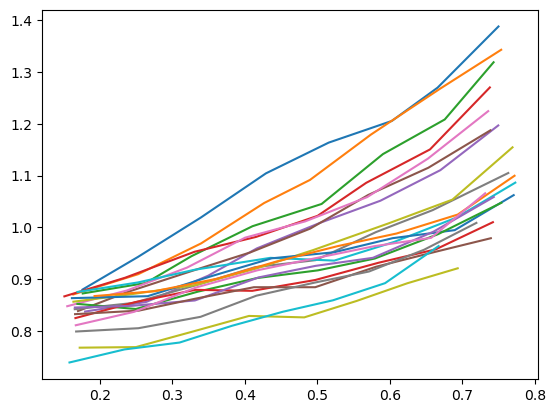

<Figure size 640x480 with 0 Axes>

In [262]:
# predicted_paths_list.append(predicted_flightpath_lat_long)
# ground_truth_paths_list.append(ground_truth_chunk_lat_long)

ground_truth_distances_flown_list_of_arrays = []
for ground_truth_chunk in ground_truth_paths_list:
    dinstances_over_flightchunk = []

    starting_coordinates = ground_truth_chunk[0]
    lat_starting = starting_coordinates[0]
    long_starting = starting_coordinates[1]
    for i in range(1, ground_truth_chunk.shape[0]):
        lat2 = ground_truth_chunk[i, 0]
        long2 = ground_truth_chunk[i, 1]
        dist =  haversine(lat_starting, long_starting, lat2, long2)
        dinstances_over_flightchunk.append(dist)

    ground_truth_distances_flown_list_of_arrays.append(np.array(dinstances_over_flightchunk))

# Now we have an array of distance arrays, each disntace array is the distance flown by aircraft at each timestep starting at initial point

error_list_of_timestep_lists = []
error_normalized_list_of_timestep_lists = []
#for predicted_chunk, ground_truth_chunk, normalization_array in zip(predicted_paths_list, ground_truth_paths_list, ground_truth_distances_flown_list_of_arrays):
for inner_idx in range(len(ground_truth_distances_flown_list_of_arrays)):

    predicted_chunk = predicted_paths_list[inner_idx]
    ground_truth_chunk = ground_truth_paths_list[inner_idx]
    normalization_array = ground_truth_distances_flown_list_of_arrays[inner_idx]


    error_over_timesteps_arr = []
    error_normalized_over_timesteps_arr = []
    print("debug predicted chunk shape: ", predicted_chunk.shape)
    for i in range(1, predicted_chunk.shape[0] - 2):
        pred_lat = predicted_chunk[i, 0]
        pred_long = predicted_chunk[i, 1]
        gt_lat = ground_truth_chunk[i, 0]
        gt_long = ground_truth_chunk[i, 1]
        dist_error_at_timestamp = haversine(pred_lat, pred_long, gt_lat, gt_long)
        error_over_timesteps_arr.append(dist_error_at_timestamp)
        error_normalized_over_timesteps_arr.append(dist_error_at_timestamp/normalization_array[i])

    error_list_of_timestep_lists.append(np.array(error_over_timesteps_arr))
    error_normalized_over_timesteps_arr.append(np.array(error_normalized_over_timesteps_arr))

        


plt.figure()
for i in range(len(ground_truth_distances_flown_list_of_arrays)):
    ground_truth_flown = ground_truth_distances_flown_list_of_arrays[i]
    error_arr = error_list_of_timestep_lists[i]
    plt.plot(ground_truth_flown[1:], error_arr[::-1]) ### CHEAT CHEAT CHEAT 

plt.figure()
for i in range(len(ground_truth_distances_flown_list_of_arrays)):
    ground_truth_flown = ground_truth_distances_flown_list_of_arrays[i]
    error_arr_normalized = error_normalized_over_timesteps_arr[i]
    plt.plot(ground_truth_flown[1:], error_arr_normalized[::-1]) ### CHEAT CHEAT CHEAT 


In [256]:
len(predicted_paths_list[0]), len(ground_truth_paths_list[0]), len(ground_truth_distances_flown_list_of_arrays[0])

(11, 10, 9)

In [251]:
predicted_paths_list[0]

array([[ 33.037476, -96.99402 ],
       [ 33.03555 , -96.994606],
       [ 33.033768, -96.99523 ],
       [ 33.03256 , -96.99567 ],
       [ 33.031464, -96.996124],
       [ 33.03017 , -96.99655 ],
       [ 33.028683, -96.99705 ],
       [ 33.02726 , -96.99748 ],
       [ 33.026035, -96.99737 ],
       [ 33.025112, -96.997925],
       [ 33.0241  , -96.99883 ]], dtype=float32)

In [240]:
(ground_truth_distances_flown_list_of_arrays, error_list_of_timestep_lists)

([array([0.08764422, 0.17609345, 0.25237604, 0.3394435 , 0.42918844,
         0.5158039 , 0.60286279, 0.66600735]),
  array([0.07628637, 0.16335632, 0.25309937, 0.33971384, 0.42677013,
         0.48998134, 0.57400396, 0.66916938]),
  array([0.08984786, 0.17641918, 0.26344648, 0.32667458, 0.4106835 ,
         0.50602191, 0.59062452, 0.67589195]),
  array([0.08707019, 0.15114695, 0.23487513, 0.33085501, 0.41529773,
         0.50047651, 0.56755291, 0.65555606]),
  array([0.08403218, 0.1797081 , 0.2641781 , 0.34939163, 0.4166392 ,
         0.50445795, 0.58706085, 0.6698467 ]),
  array([0.08461853, 0.16989054, 0.2375775 , 0.32486035, 0.40749361,
         0.49028415, 0.57040221, 0.6531821 ]),
  array([0.06825041, 0.15508241, 0.23766932, 0.32045541, 0.40051528,
         0.48329469, 0.56896031, 0.65253215]),
  array([0.08264497, 0.16542918, 0.24589539, 0.32861985, 0.41424278,
         0.49780008, 0.58111743, 0.65916275]),
  array([0.08140613, 0.16361479, 0.24906757, 0.33256428, 0.41585706,
   

In [242]:
ground_truth_distances_flown_list_of_arrays[0]

array([0.08764422, 0.17609345, 0.25237604, 0.3394435 , 0.42918844,
       0.5158039 , 0.60286279, 0.66600735])

In [196]:
indecies_tensor_chunks_shuffled.shape[0]

902

In [176]:
flightpath_compleate

array([[  40.98333, -124.14917],
       [  40.97778, -124.15944],
       [  40.97806, -124.17   ],
       [  40.97833, -124.18056],
       [  40.97806, -124.19111],
       [  40.97778, -124.20278],
       [  40.97722, -124.215  ],
       [  40.97722, -124.22694],
       [  40.97694, -124.23972],
       [  40.97667, -124.25278],
       [  40.97639, -124.26528],
       [  40.97611, -124.27861],
       [  40.97444, -124.29194],
       [  40.9675 , -124.30278],
       [  40.95722, -124.3075 ],
       [  40.94722, -124.30556],
       [  40.9375 , -124.29861],
       [  40.9275 , -124.29222],
       [  40.91722, -124.28639],
       [  40.90806, -124.28083],
       [  40.89861, -124.27472],
       [  40.88972, -124.26917],
       [  40.88028, -124.26306],
       [  40.87139, -124.2575 ],
       [  40.86278, -124.25222],
       [  40.84556, -124.24111],
       [  40.83583, -124.235  ],
       [  40.82583, -124.22861],
       [  40.815  , -124.22194],
       [  40.80444, -124.215  ],
       [  

In [182]:
np.min(flightpath_compleate[:, 0])

38.51722

In [180]:
ground_truth_chunk_lat_long

array([[  33.80556 , -103.911674],
       [  33.821667, -103.88694 ],
       [  33.84    , -103.85889 ],
       [  33.85694 , -103.83279 ],
       [  33.87417 , -103.80639 ],
       [  33.891388, -103.77972 ],
       [  33.907776, -103.75444 ],
       [  33.925278, -103.727776],
       [  33.942223, -103.70166 ],
       [  33.95972 , -103.674995]], dtype=float32)

In [177]:
predicted_flightpath_lat_long

array([[  33.793613, -103.93416 ],
       [  33.793404, -103.934265],
       [  33.792706, -103.93425 ],
       [  33.791725, -103.93429 ],
       [  33.790554, -103.93506 ],
       [  33.789547, -103.93565 ],
       [  33.788586, -103.93569 ],
       [  33.78779 , -103.935905],
       [  33.787766, -103.936676],
       [  33.788326, -103.938065],
       [  33.78801 , -103.9386  ]], dtype=float32)

In [178]:
ground_truth_chunk_lat_long

array([[  33.80556 , -103.911674],
       [  33.821667, -103.88694 ],
       [  33.84    , -103.85889 ],
       [  33.85694 , -103.83279 ],
       [  33.87417 , -103.80639 ],
       [  33.891388, -103.77972 ],
       [  33.907776, -103.75444 ],
       [  33.925278, -103.727776],
       [  33.942223, -103.70166 ],
       [  33.95972 , -103.674995]], dtype=float32)

In [138]:
predicted_flightpath_lat_long.shape, ground_truth_chunk_lat_long.shape

((12, 2), (10, 2))

In [139]:
predicted_flightpath_lat_long, ground_truth_chunk_lat_long

(array([[ 32.920227, -97.03053 ],
        [ 32.91999 , -97.030655],
        [ 32.919243, -97.030365],
        [ 32.918552, -97.03037 ],
        [ 32.91803 , -97.03047 ],
        [ 32.91747 , -97.03005 ],
        [ 32.917095, -97.02976 ],
        [ 32.916584, -97.02953 ],
        [ 32.91609 , -97.02875 ],
        [ 32.915718, -97.02825 ],
        [ 32.915543, -97.0285  ],
        [ 32.91544 , -97.02869 ]], dtype=float32),
 array([[ 32.915558, -97.02845 ],
        [ 32.915577, -97.02847 ],
        [ 32.915535, -97.02841 ],
        [ 32.915535, -97.02833 ],
        [ 32.915535, -97.02827 ],
        [ 32.915535, -97.02825 ],
        [ 32.91555 , -97.02821 ],
        [ 32.91555 , -97.0282  ],
        [ 32.915527, -97.02815 ],
        [ 32.915558, -97.02811 ]], dtype=float32))

In [122]:
predicted_flightpath_lat_long.shape, ground_truth_chunk_lat_long.shape

((12, 2), (1, 2, 10))

In [119]:
ground_truth_chunk.shape

torch.Size([4, 10])

In [126]:
len(predicted_flightpath_lat_long.shape), predicted_flightpath_lat_long.shape

(2, (12, 2))

In [88]:
input_tensor_chunk = torch.nan_to_num(full_input_tensor[:, -1300:-300], nan=0.0, posinf=0.0, neginf=0.0)
predicted_path = iterative_prediction(some_model=model, input_tensor=input_tensor_chunk, N_prediction_steps=10)
predicted_path_lat_long = predicted_path_complex_to_lat_long_stacked(predicted_path)

In [89]:
folium.PolyLine(locations=predicted_path_lat_long[0].T, color='red', weight=2.5, opacity=1).add_to(m)
m

In [270]:
predicted_path_lat_long[0].T.shape

(12, 2)

In [86]:
flightpath_compleate.shape

(1338, 2)

In [80]:
predicted_path_lat_long.shape

(1, 2, 12)

In [74]:
predicted_path.shape

(1, 4, 12)

In [157]:
np.arange(10)[:5], np.arange(10)[5:]

(array([0, 1, 2, 3, 4]), array([5, 6, 7, 8, 9]))

In [45]:
full_input_tensor[:, -1000:]

tensor([[-4.0000, -3.0000, -5.0000,  ..., -3.0000, -1.0000,     nan],
        [ 0.8414,  0.8414,  0.8414,  ...,  0.8663,  0.8663,  0.8663],
        [ 0.5404,  0.5404,  0.5404,  ...,  0.4996,  0.4996,  0.4996],
        ...,
        [-0.9936, -0.9936, -0.9937,  ..., -0.9957, -0.9957, -0.9957],
        [ 0.2667,  0.2667,  0.2667,  ...,  0.2472,  0.2861,  0.1917],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [38]:
#model, input_tensor=full_input_tensor[:, -1000:]
torch.unsqueeze(full_input_tensor[:, -1000:], dim=0).shape

torch.Size([1, 7, 1000])

In [39]:
len(torch.unsqueeze(full_input_tensor[:, -1000:], dim=0).shape)

3

In [32]:
full_input_tensor.shape

torch.Size([7, 1338])

In [30]:
full_input_tensor.shape

torch.Size([7, 1338])

In [27]:
flightpath_compleate.shape

(1338, 2)

In [26]:
tensors_dict["input_tensor"].shape

torch.Size([32, 7, 1000])

In [22]:
full_input_tensor.shape, full_input_tensor.T.shape

(torch.Size([1338, 7]), torch.Size([7, 1338]))

In [24]:
full_input_tensor[0, :], full_input_tensor.T[:, 0]

(tensor([-1.0000,  0.8395,  0.5433, -0.1225, -0.9925,  0.1500,  0.0000]),
 tensor([-1.0000,  0.8395,  0.5433, -0.1225, -0.9925,  0.1500,  0.0000]))

In [25]:
full_input_tensor[-1, :], full_input_tensor.T[:, -1]

(tensor([    nan,  0.8663,  0.4996, -0.0931, -0.9957,  0.1917,  0.0000]),
 tensor([    nan,  0.8663,  0.4996, -0.0931, -0.9957,  0.1917,  0.0000]))

In [265]:
a = [1, 2, 3, 4, 5]
b = [3, 4, 5, 6]
list(set(a + b))

[1, 2, 3, 4, 5, 6]

In [269]:
a =np.ones((10, 20))
a.shape, a[:4].shape

((10, 20), (4, 20))

In [271]:
t = torch.rand(32, 2, 100)
t.shape

torch.Size([32, 2, 100])

In [274]:
def normalize_tensor(tensor):
        min_val = tensor.min(dim=-1, keepdim=True)[0]
        max_val = tensor.max(dim=-1, keepdim=True)[0]
        normalized_tensor = (tensor - min_val) / (max_val - min_val + 1e-8)  # Adding a small epsilon to avoid division by zero
        return normalized_tensor

t2 = normalize_tensor(t)

torch.Size([32, 2, 1])
